In [35]:
'''This script is a part of mercari price prediction'''
   
__author__ = 'Sandeep Kumar Kola'
__email__ = 'sandeep.kola07@gmail.com'

In [36]:
# Import the required libraries
import gc
import time 
import string
import numpy as np
import pandas as pd
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.linear_model import Ridge
from nltk.stem.porter import PorterStemmer      
from sklearn.cross_validation import KFold
from sklearn.preprocessing import LabelBinarizer
from scipy.sparse import vstack, hstack, csr_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [42]:
class Data:
    """
    Class data has function that cleans the data.
    """
    def __init__(self, path):
        self.path = path
        
    def _load_data(path):
        """
        _load_data loads the data files.

        Parameters:
        ----------
        path : Path where data files are present.

        Returns:
        -------
        train : data for the model.
        y : log values of the price variable.
        """
        train = pd.read_csv(path, sep = '\t')
        y = np.log1p(train['price'])
        print("-- The data has been successfully loaded --")
        return y, train
    
    def _clean_data():
        punctuation_symbols = []
        for symbol in punctuation:
            punctuation_symbols.append((symbol, ''))
            
    def remove_punctuation(sentence: str) -> str:
        return sentence.translate(str.maketrans('', '', string.punctuation))

    def remove_digits(x):
        x = ''.join([i for i in x if not i.isdigit()])
        return x  

    def remove_stop_words(x):
        stop = stopwords.words('english')
        x = ' '.join([i for i in x.lower().split(' ') if i not in stop])
        return x  
    
    def to_lower(x):
        return x.lower()

In [38]:
class ExploratoryAnalysis:
    """
    This class has all the exploratory functions for the model.
    """
    def _price_distribution(train):
        """
        _price_distribution is the distribution of price across the dataset.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : histogram of the price values.
        """
        print("-- Building histogram for price distribution -- ")
        bins = [0, 10, 17, 29, 2001]
        labels = ['q1','q2','q3','q4']
        train['price_bin'] = pd.cut(train['price'], bins=bins, labels=labels)
        train.groupby('price_bin')['price'].describe()
        
        plt.figure(figsize=(12, 7))
        plt.hist(train['price'], bins=50, range=[0,250], label='price')
        plt.title('Price Distribution', fontsize=15)
        plt.xlabel('Price', fontsize=15)
        plt.ylabel('Samples', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(fontsize=15)
        plt.show()       
        return plt.show()

    def _price_shipping_dist(train):   
        """
        _price_shipping_dist is the distribution of price across the dataset
         with and wihtout shipping.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : histogram of the price values with and without shipping.
        """
        print("-- Building histogram for price distribution (shipping/no shipping)-- ")        
        shipping = train[train['shipping']==1]['price']
        no_shipping = train[train['shipping']==0]['price']      
        plt.figure(figsize=(12,7))
        plt.hist(shipping, bins=50, normed=True, range=[0,250], alpha=0.7, 
                 label='Price With Shipping')
        plt.hist(no_shipping, bins=50, normed=True, range=[0,250], 
                 alpha=0.7, label='Price With No Shipping')
        plt.title('Price Distrubtion With/Without Shipping', fontsize=15)
        plt.xlabel('Price')
        plt.ylabel('Normalized Samples')
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.legend(fontsize=15)
        plt.show()
        return plt.show()

    def _brand_dist(train):
        """
        _brand_dist is the distribution of top 20 brands across the dataset.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : barplot of the top 20 brands.
        """
        print("-- Building barplot for brand distribution -- ")
        train['brand_name'].nunique()    
        b20 = train['brand_name'].value_counts()[0:20].reset_index().rename(
            columns={'index': 'brand_name', 'brand_name':'count'})
        ax = sns.barplot(x="brand_name", y="count", data=b20)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.set_title('Top 20 Brand Distribution', fontsize=15)
        plt.show()
        return plt.show()
        
    def _expensive_brands(train):
        """
        _expensive_brands is the top 20 Expensive Brands By Mean Price.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : barplot of the top 20 Expensive Brands By Mean Price.
        """
        print("-- Building barplot for top 20 brand distribution -- ")
        top20_brand = train.groupby('brand_name', axis=0).mean()
        df_expPrice = pd.DataFrame(top20_brand.sort_values('price', 
                            ascending = False)['price'][0:20].reset_index())
        ax = sns.barplot(x="brand_name", y="price", data=df_expPrice)
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=15)
        ax.set_title('Top 20 Expensive Brand', fontsize=15)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.show()
        return plt.show()
        
    def _transform_category_name(category_name):
        """
        Splits the category name by "/" and gives out three variables if present.
        """
        try:
            main, sub1, sub2= category_name.split('/')
            return main, sub1, sub2
        except:
            return np.nan, np.nan, np.nan
        
    def _sub_category_dist(train):
        """
        _sub_category_dist uses above function and splits the category into 3.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : countplot of the top 10 categories.
        """
        print("-- Building countplot for Category distribution -- ")
        train['category_main'], train['category_sub1'], train['category_sub2'] = \
                zip(*train['category_name'].apply(ExploratoryAnalysis. \
                                                  _transform_category_name))
        cat_train = train[['category_main','category_sub1','category_sub2', 'price']]     
        plt.figure(figsize=(17,10))
        sns.countplot(y = train['category_main'], 
                      order = train['category_main'].value_counts().index, orient = 'v')
        plt.title('Top 10 Categories', fontsize = 25)
        plt.ylabel('Main Category', fontsize = 20)
        plt.xlabel('Number of Items in Main Category', fontsize = 20)
        plt.show()        
        return plt.show()
    
    def _price_category_dist(train):
        """
        _price_category_dist is the distribution of price with category.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : boxplot of the category_main.
        """
        print("-- Building boxplot for category_main -- ")
        cat_train = train[['category_main','category_sub1','category_sub2', 'price']]
        fig, axes = plt.subplots(figsize=(12, 7))
        main = cat_train[cat_train["price"]<100]
        ax = sns.boxplot( x=main["category_main"], y=main["price"], palette="Blues")
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90, fontsize=12)
        plt.show()       
        return plt.show()
        
    def _no_brand_dist(train):
        """
        _no_brand_dist is the distribution of price with category "no brand".

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : countplot of the category_main.
        """
        print("-- Building countplot for category_main -- ")
        train['no_brand'] = train['brand_name'].isnull()
        f, ax = plt.subplots(figsize=(15, 4))
        sns.countplot(y='category_main', hue='no_brand', 
                      data=train).set_title('Category Distribution With/Without Brand');
        plt.show()    
        return plt.show()
    
    def _category_sub2_dist(train): 
        """
        _category_sub2_dist is the distribution of price with category_sub2.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : barh of the category_sub2.
        """
        print("-- Building barh for category_sub2 -- ")
        cat_train = train[['category_main','category_sub1','category_sub2', 'price']]
        df = cat_train.groupby(['category_sub2'])['price'].agg(['mean']).reset_index().\
                            rename(columns={'index': 'main', 'category_main':'count'})
        df= df.sort_values('mean', ascending=False).head(20)     
        plt.figure(figsize=(20, 15))
        plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='r')
        plt.yticks(range(0,len(df)), df['category_sub2'], fontsize=15)
        plt.xlabel('Price', fontsize=15)
        plt.ylabel('Sub Category 2', fontsize=15)
        plt.title('Top 20 2nd Category (Mean Price)', fontsize=20)
        plt.show()        
        return plt.show()
    
    def _category_sub1_dist(train):
        """
        _category_sub1_dist is the distribution of price with category_sub1.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : barh of the category_sub1.
        """
        print("-- Building barh for category_sub1 -- ")
        cat_train = train[['category_main','category_sub1','category_sub2', 'price']]
        df = cat_train.groupby(['category_sub1'])['price'].agg(['mean']).\
                    reset_index().rename(columns={'index': 'main', 'category_main':'count'})
        df= df.sort_values('mean', ascending=False)[0:20]       
        plt.figure(figsize=(20, 15))
        plt.barh(range(0,len(df)), df['mean'], align='center', alpha=0.5, color='b')
        plt.yticks(range(0,len(df)), df['category_sub1'], fontsize=15)       
        plt.xlabel('Price', fontsize=15)
        plt.ylabel('Sub Category 1', fontsize=15)
        plt.title('Top 20 1st Category (Mean Price)', fontsize=20)
        plt.show()  
        return plt.show()

In [39]:
class PreprocessData:
    """
    PreprocessData has functions that cleans the data.
    """
    def _tidy_data(train):
        """
        _tidy_data cleans up the data.

        Parameters:
        ----------
        train : data.

        Returns:
        -------
        plt.show() : regplot of the word count of item_description.
        """
        train.item_description = train.item_description.astype(str)
        descr = train[['item_description', 'price']]
        descr['count'] = descr['item_description'].apply(lambda x : len(str(x)))   
        descr['item_description'] = descr['item_description'].apply(Data.remove_digits)
        descr['item_description'] = descr['item_description'].apply(Data.remove_punctuation)
        descr['item_description'] = descr['item_description'].apply(Data.remove_stop_words)       
        porter = PorterStemmer()        
        descr['item_description'] = descr['item_description'].apply(porter.stem)    
        df = descr.groupby('count')['price'].mean().reset_index()
        sns.regplot(x=df["count"], y=(df["price"]))
        plt.xlabel("word count")
        plt.show()
        print("-- Data cleaning successfully finished --")
        return plt.show()
        
    def handle_missing_values(df):
        """
        Missing values imputing.
        """
        df['category_name'].fillna(value='missing', inplace=True)
        df['brand_name'].fillna(value='None', inplace=True)
        df['item_description'].fillna(value='None', inplace=True)

    def to_categorical(df):
        """
        categorical values conversion.
        """
        df['brand_name'] = df['brand_name'].astype('category')
        df['category_name'] = df['category_name'].astype('category')
        df['item_condition_id'] = df['item_condition_id'].astype('category')
        
    def _preprocess(train):
        """
        _preprocess cleans up the data.

        Parameters:
        ----------
        train : data.
        """
        PreprocessData.handle_missing_values(train)
        PreprocessData.to_categorical(train)
        train.item_description = train.item_description.astype(str)
        train['item_description'] = train['item_description'].apply(Data.remove_digits)
        train['item_description'] = train['item_description'].apply(Data.remove_punctuation)
        train['item_description'] = train['item_description'].apply(Data.remove_stop_words)
        train['item_description'] = train['item_description'].apply(Data.to_lower)       
        train['name'] = train['name'].apply(Data.remove_digits)
        train['name'] = train['name'].apply(Data.remove_punctuation)
        train['name'] = train['name'].apply(Data.remove_stop_words)
        train['name'] = train['name'].apply(Data.to_lower)
        print("-- Data pre-processing successfully finished --")


In [40]:
class Model:
    """
    class Model builds the model for the data.
    """
    def rmsle(y, y0):
        """
        Error function to measure the error of the model.
        """
        assert len(y) == len(y0)
        return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))
  
    def _model(train):
        """
        _model builds and trains a ridge model.
        
        Parameters:
        ----------
        train : data.

        Returns:
        -------
        preds_valid : predicted values of prices.
        
        """
        print("-- Applying NLP techniques to transform the data --")
        cv = CountVectorizer(min_df=10)
        X_name = cv.fit_transform(train['name'])      
        cv = CountVectorizer()
        X_category = cv.fit_transform(train['category_name'])      
        tv = TfidfVectorizer(max_features=55000, ngram_range=(1, 2), stop_words='english')
        X_description = tv.fit_transform(train['item_description'])            
        lb = LabelBinarizer(sparse_output=True)
        X_brand = lb.fit_transform(train['brand_name'])        
        X_dummies = csr_matrix(pd.get_dummies(train[['item_condition_id', 'shipping']], 
                                              sparse=True).values)
        sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, 
                               X_name)).tocsr()        
        X_train_sparse = sparse_merge  
        print(" -- Doing K fold cross validation --")
        eval_size = .10
        y = np.log1p(train['price'])
        kf = KFold(len(y), round(1. / eval_size))
        train_indicies, valid_indicies = next(iter(kf))
        X_train, y_train = X_train_sparse[train_indicies], y[train_indicies]
        X_valid, y_valid = X_train_sparse[valid_indicies], y[valid_indicies]
        print("-- Building the model on the provided data --")
        print("-- Using rmsle : root mean square log error function for validating the model --")
        start_time = time.time()      
        model = Ridge(solver = "sag", fit_intercept=False)      
        print("-- Fitting the Ridge Model --")
        model.fit(X_train, y_train) 
        preds_valid = model.predict(X_valid)  
        print('[{}] Ridge modelling has been completed.'.format(time.time() - start_time))
        print("Ridge rmsle: "+str(Model.rmsle(np.expm1(y_valid), np.expm1(preds_valid))))
        return preds_valid

In [43]:
if __name__ == '__main__':
    # path of the data files.
    path = "/BigVM/Project 4 Mercari/all/train.tsv"
    y, train = Data._load_data(path)

-- The data has been successfully loaded --


-- Building histogram for price distribution -- 


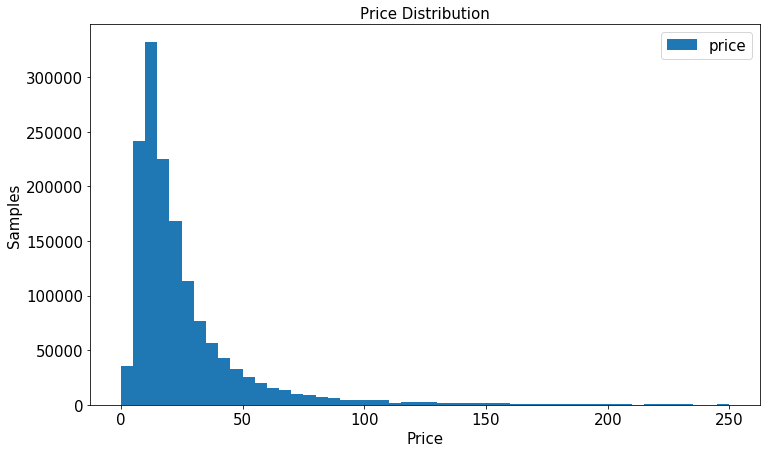

In [44]:
# Let's have a look at the price distribution of the data.
ExploratoryAnalysis._price_distribution(train)

-- Building histogram for price distribution (shipping/no shipping)-- 


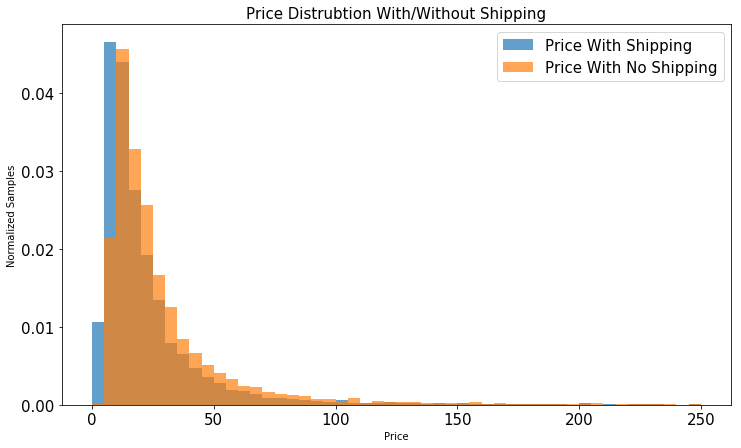

In [45]:
# Let's have a look at the price distribution of the data, with shipping variable.
ExploratoryAnalysis._price_shipping_dist(train)      

-- Building barplot for brand distribution -- 


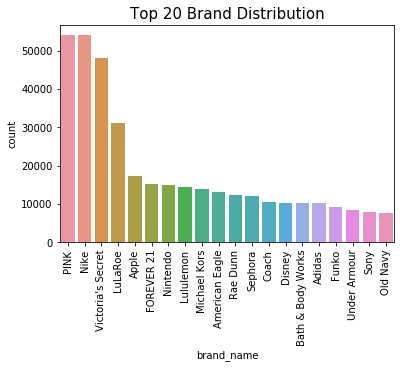

In [46]:
# Let's have a look at the brand distribution of the data.
ExploratoryAnalysis._brand_dist(train)

-- Building barplot for top 20 brand distribution -- 


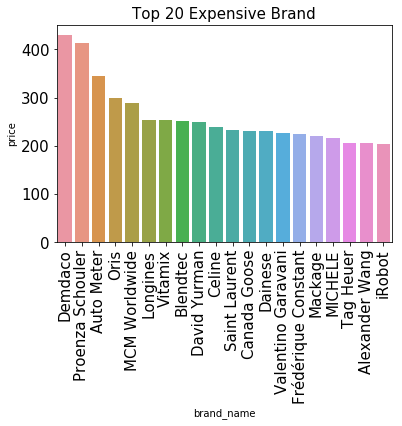

In [47]:
# Let's have a look at the top 20 brands of the data.
ExploratoryAnalysis._expensive_brands(train)

-- Building countplot for Category distribution -- 


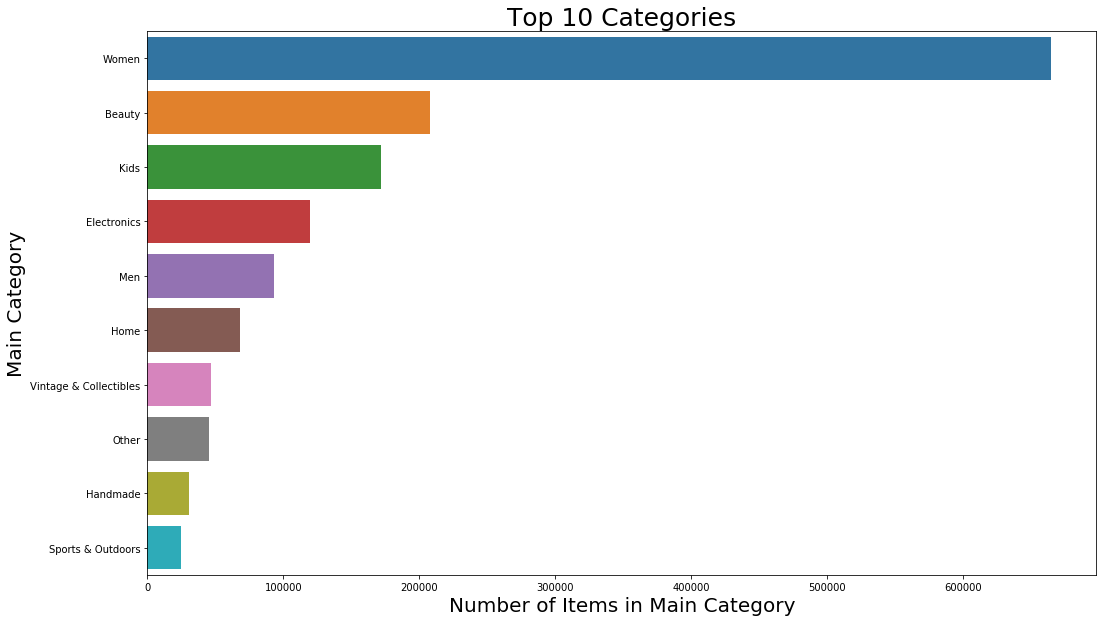

In [48]:
# Let's have a look at the top 10 categories of the data.
ExploratoryAnalysis._sub_category_dist(train)

-- Building boxplot for category_main -- 


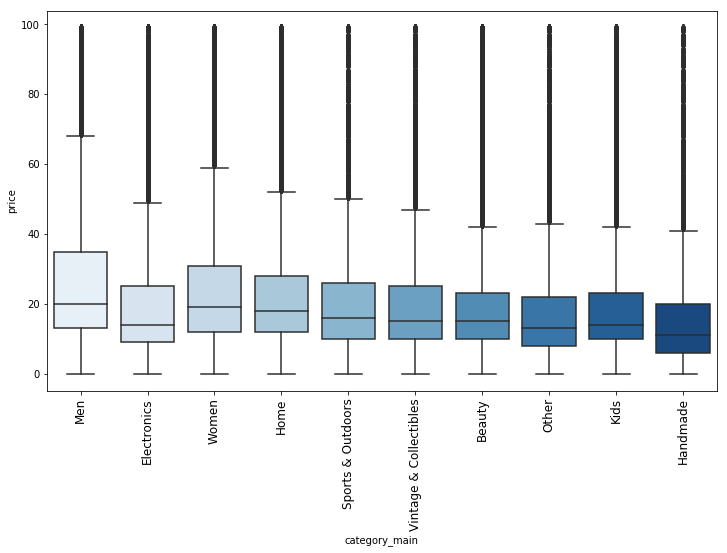

In [49]:
# Let's have a look at the price distribution of the data top 10 categories.
ExploratoryAnalysis._price_category_dist(train)

-- Building countplot for category_main -- 


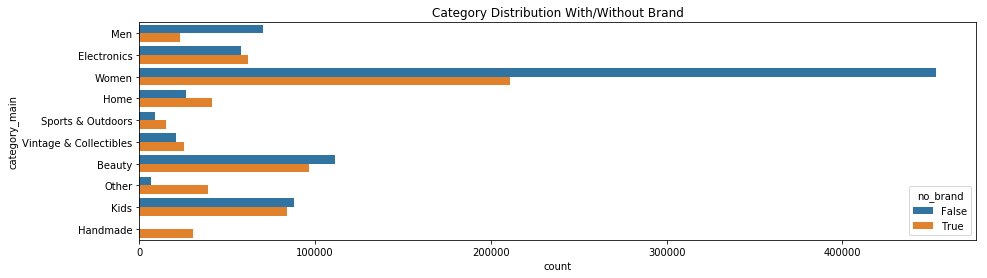

In [50]:
# Let's have a look at the category distribution of the data with no brand.
ExploratoryAnalysis._no_brand_dist(train)

-- Building barh for category_sub2 -- 


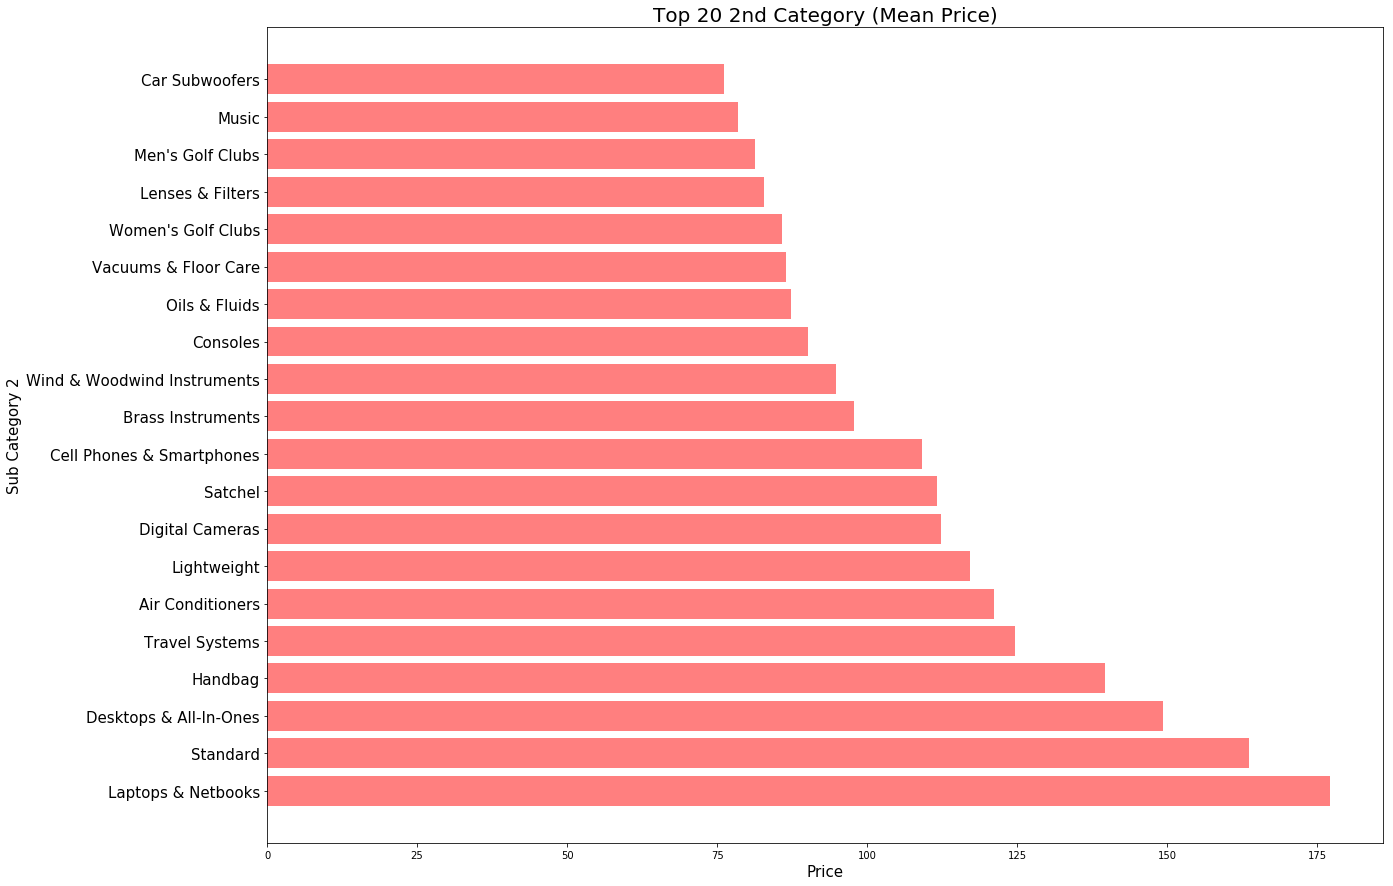

In [51]:
# Let's have a look at top 20 second category distribution of the data.
ExploratoryAnalysis._category_sub2_dist(train)     

-- Building barh for category_sub1 -- 


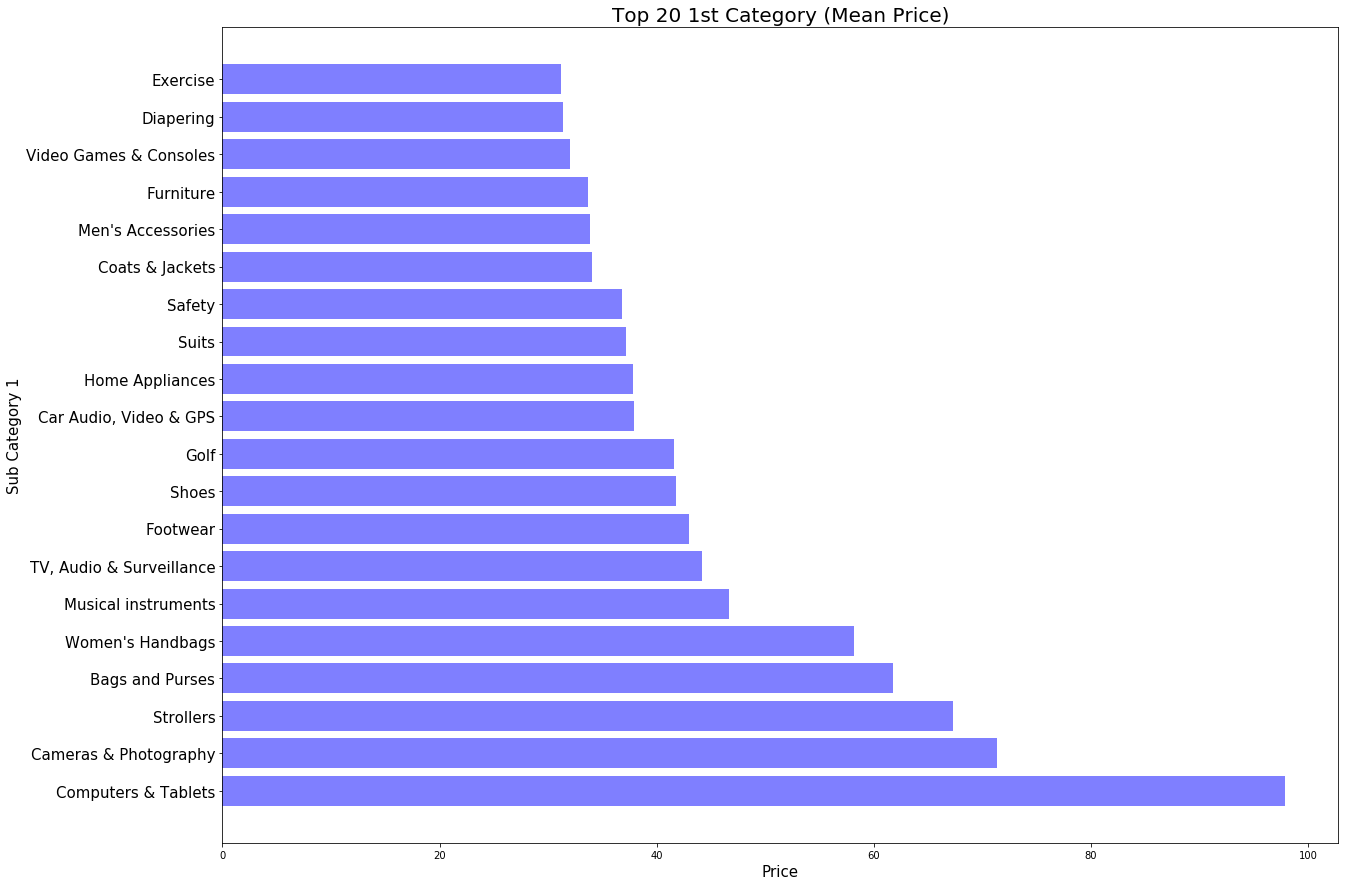

In [52]:
# Let's have a look at top 20 first category distribution of the data.
ExploratoryAnalysis._category_sub1_dist(train)     

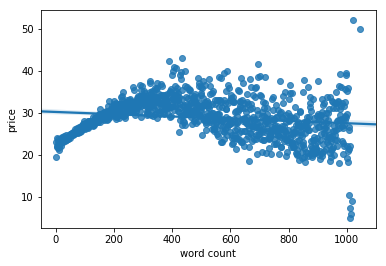

-- Data cleaning successfully finished --


In [53]:
# Let's tidy up the data a little bit.
PreprocessData._tidy_data(train)

In [54]:
# Let's pre-process  the data a little bit.
PreprocessData._preprocess(train)

-- Data pre-processing successfully finished --


In [55]:
# Let's build the model.
Model._model(train)

-- Applying NLP techniques to transform the data --
 -- Doing K fold cross validation --
-- Building the model on the provided data --
-- Using rmsle : root mean square log error function for validating the model --
-- Fitting the Ridge Model --
[165.9685001373291] Ridge modelling has been completed.
Ridge rmsle: 0.4706522898576605


In [ ]:
# Save the predicted prices to a csv file.
suggested_price = np.expm1(preds_valid)
suggested_price.to_csv("suggested_price.csv", index = False)

### Report:

* Objective: The objective is to come up with the right pricing algorithm that can be can used as a pricing recommendation to the users.

* How will the solution be used?
* Allowing the users to see a suggest price before purchasing or selling will hopefully allow more transaction within Mercari's business.

* Framing the problem: This problem can be solved using a supervised learning approach, and possible some unsupervised learning methods as well for clustering analysis.

* Performance measure: RMSLE (Root Mean Squared Log Error) is used as error function.

* Any other data sets that can be used? To get a more accurate understanding and prediction for this problem, a potential dataset that we can gather would be more about the user. Features such as user location, user gender, and time could affect it.

* General Steps

* Handle Missing Values — Replaced “missing” values with NA.

* Lemmatization performed on item_description — Aiming to remove inflectional endings only and to return the base or dictionary form of a word

* Label encoding has been performed on categorical values — Encode labels with value between 0 and n_classes-1.

* Tokenization has been performed on the data.

* Maximum length of all sequences has been specified.

* Scaling performed on target variable (price) log scale is performed.

* Sentiment scored computed on item_description.

* Scaling performed on item description length 

#### Major Observations:

* Women and Beauty take up majority of the distribution.
* Women and Beauty take up 56% of the distribution.